# LAB 3 - AUTOREGRESSIVE MODELS

In this lab, you will be given two tasks:

1. Explore and understand code fitting autoregressive models to forecast the monthly mean north Atlantic oscillation index.

2. Develop yourself code to forecast US treasury bills' values using autoregressive models.

## PART 1 - NAO INDEX DATA

The time series dataset `nao.xlsx` stores the monthly mean north Atlantic oscillation (NAO) index
from January 1950 to December 2018. The NAO index is important for weather research and is based on the surface sea level pressure difference between the subtropical (Azores) high and the subpolar low. The code below produces its time series plot.

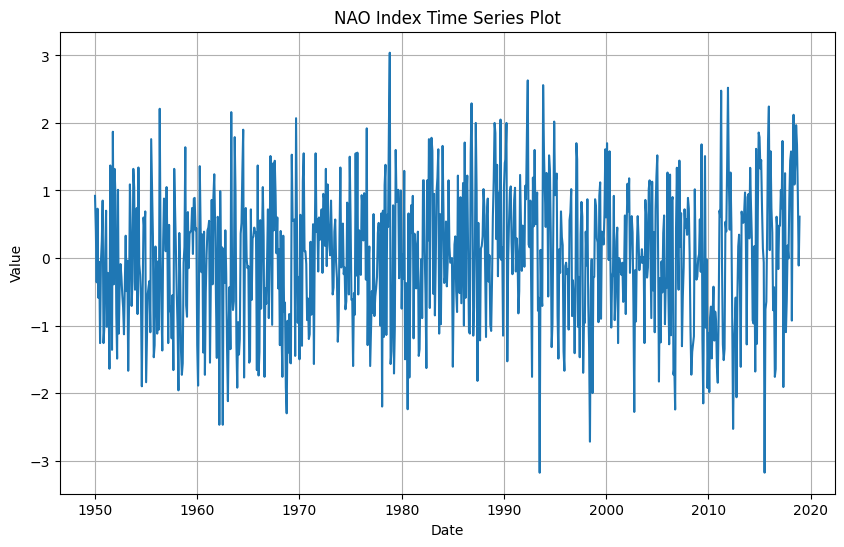

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel file; ensure 'date' is parsed as a datetime column
df = pd.read_excel("CSV_FILES/nao.xlsx", parse_dates=['date'])

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['index'],  linestyle='-')
plt.title("NAO Index Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

We are going to assume the data is stationary (you could run a stationarity test if you like to). The following code produces the ACF and PACF plots. What do they tell us?

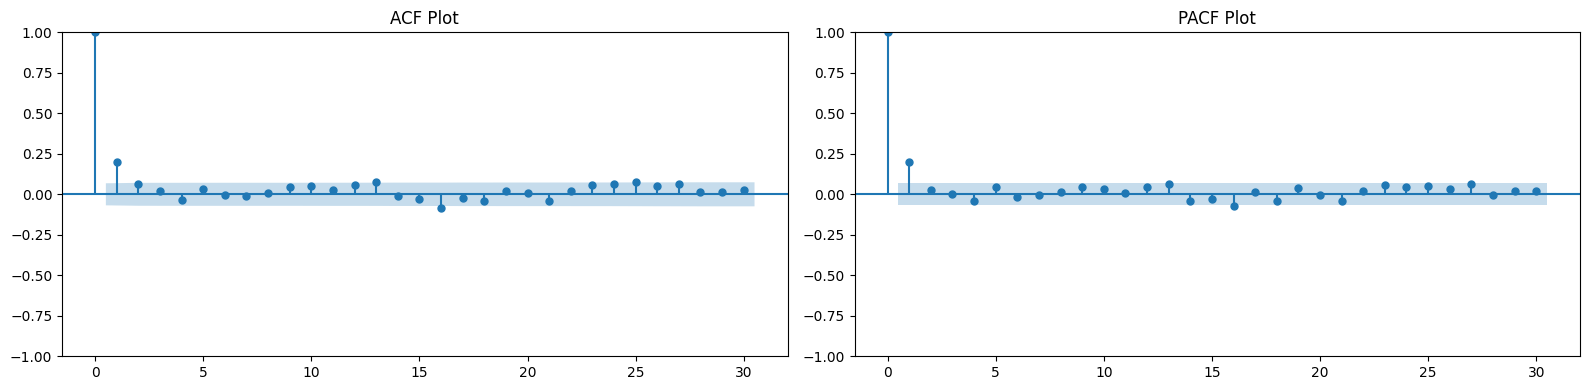

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots: one for ACF and one for PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Generate the ACF plot for the 'index' column
plot_acf(df['index'], ax=ax[0])
ax[0].set_title("ACF Plot")

# Generate the PACF plot for the 'index' column
plot_pacf(df['index'], ax=ax[1])
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

If you interpreted the above plots correctly, you should consider using an AR(1) model since the only significant partial autocorrelation is at lag 1. The following code fits and AR(1) model through the ARIMA function. To fit the AR(1) model we set the `order` argument to `(1,0,0)`. Interpret the coefficients of the estimated model.

In [3]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an AR(1) model (i.e., ARIMA(1, 0, 0))
model = ARIMA(df['index'], order=(1, 0, 0))
results = model.fit()

# Print the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  index   No. Observations:                  828
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1172.443
Date:                Tue, 25 Feb 2025   AIC                           2350.887
Time:                        17:19:47   BIC                           2365.044
Sample:                             0   HQIC                          2356.317
                                - 828                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.043      0.029      0.977      -0.084       0.086
ar.L1          0.1987      0.033      6.005      0.000       0.134       0.264
sigma2         0.9941      0.054     18.401      0.0

Although the PACF model was fairly clear about which model would be best, let's use a machine-learning approach and let's compute the BIC of all AR(p) models for p from 1 to 10. This can be done adapting the first entry of the argument `order` Which model does seem to be best according to the output?

In [4]:
# List to store results for each AR(p) model
results = []

# Fit AR(p) models for p = 1 to 10 and record AIC and BIC
for p in range(1, 11):
    model = ARIMA(df['index'], order=(p, 0, 0))
    res = model.fit()
    results.append({'p': p, 'AIC': res.aic, 'BIC': res.bic})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the table of AIC and BIC values
print(results_df)

    p          AIC          BIC
0   1  2350.886894  2365.043933
1   2  2352.254541  2371.130593
2   3  2354.238099  2377.833165
3   4  2354.884315  2383.198394
4   5  2355.161994  2388.195086
5   6  2356.867787  2394.619893
6   7  2358.837449  2401.308567
7   8  2360.730019  2407.920150
8   9  2360.946023  2412.855168
9  10  2362.166524  2418.794682


Before performing any forecasting, let's carry out a residual analysis for the AR(1) model. The following code creates the four residual plots we have introduce in class. Interpret carefully each of the plots, making sure to discuss whether they confirm a good fit of the model or not.

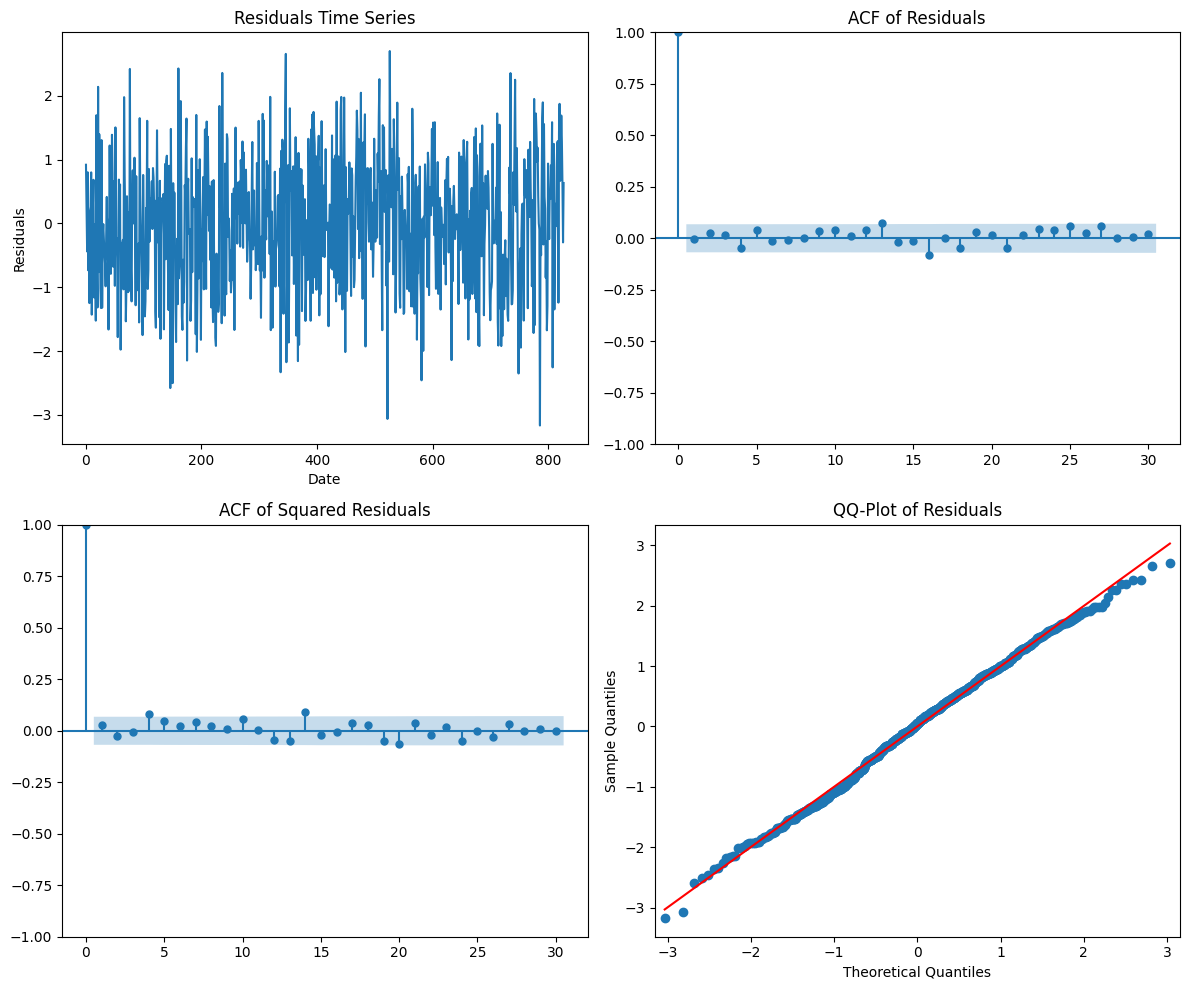

In [5]:
import statsmodels.api as sm

# Fit an AR(1) model (for example) and obtain residuals
model = ARIMA(df['index'], order=(1, 0, 0))
results = model.fit()
resid = results.resid

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Time series plot of the residuals
axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# 2. ACF plot of the residuals
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# 3. ACF plot of the squared residuals
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# 4. QQ-plot of the residuals
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

The model looks pretty good!! Let's try and do some forecasting! Of course given the data shows very little autocorrelation we have very little hope of actually predicting anything, but let's give it a go!

The following code fits the model over the full dataset except for the 2018 data. Forecasting is then conducted in an iterative one-step ahead fashion (left plot) and predicting all 12 months ahead at the end of 2017 (right plot). Notice that in the left plot the model is not estimated every time that a new observation of 2018 comes in - that observation is only used for forecasting a new value. To show more clearly the forecasts only 2017 and 2018 data is shown.

Notice here I reload the data to make the creation of train and test a bit easier.

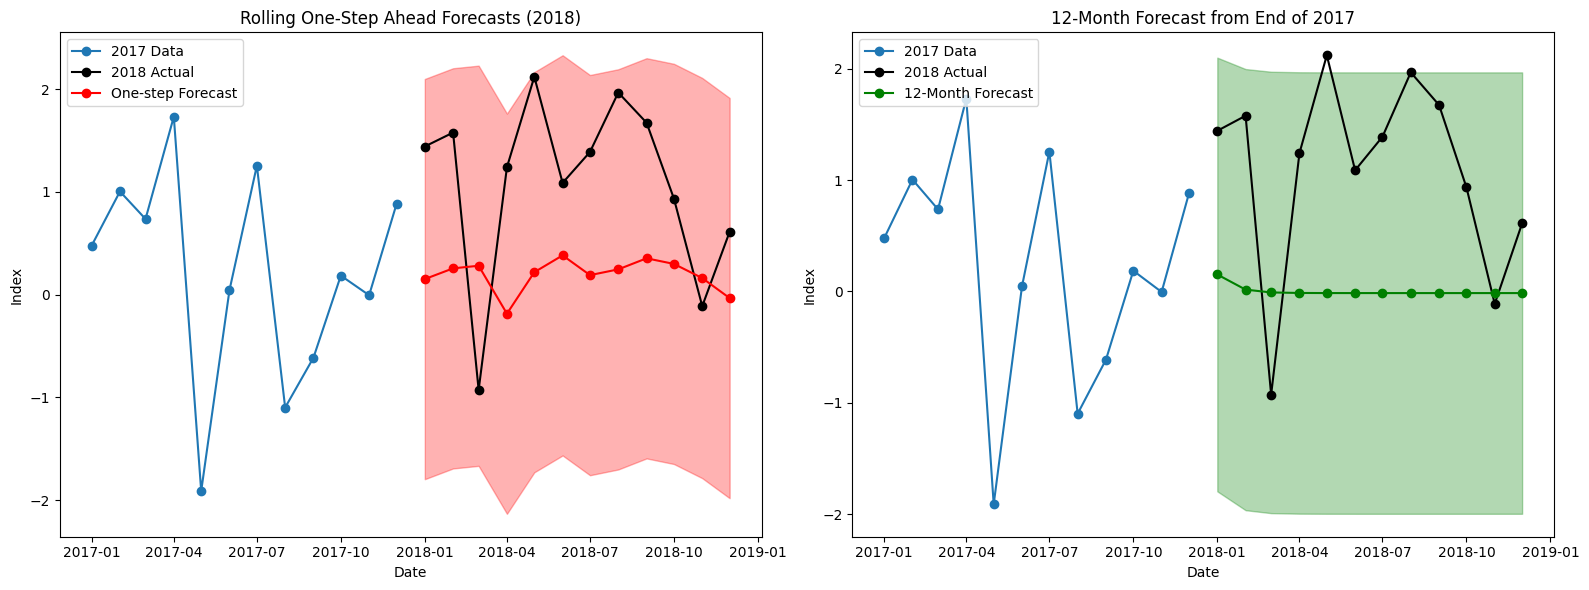

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load data, set date as index, and enforce monthly frequency
df = pd.read_excel("CSV_FILES/nao.xlsx", parse_dates=['date'])
df = df.set_index('date').asfreq('MS')

# Split data: use data before 2018 for fitting; for plotting, only 2017 and 2018 are shown.
train = df[df.index.year < 2018]
test = df[df.index.year == 2018]
train_plot = df[df.index.year == 2017]

# Fit an AR(1) model on the training data
model = ARIMA(train['index'], order=(1, 0, 0))
results = model.fit()

# 12-month forecast from the end of 2017 (static forecast)
forecast_res = results.get_forecast(steps=12)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Rolling one-step ahead forecasts for 2018 using the .append() method.
# (We update the state of the model with each new observation without refitting.)
current_results = results  # Use the fitted results directly
one_step_forecasts = []
one_step_ci_lower = []
one_step_ci_upper = []

for date in test.index:
    # Forecast one step ahead using the current state of the model
    forecast_obj = current_results.get_forecast(steps=1)
    forecast_value = forecast_obj.predicted_mean.iloc[0]
    ci = forecast_obj.conf_int()
    one_step_forecasts.append(forecast_value)
    one_step_ci_lower.append(ci.iloc[0, 0])
    one_step_ci_upper.append(ci.iloc[0, 1])

    # Update the state by appending the actual observation for the current date.
    # The .append() method returns a new results instance with the updated state.
    current_results = current_results.append(test.loc[[date]], refit=False)

# Convert the forecast lists to Series with the same index as test
one_step_forecasts = pd.Series(one_step_forecasts, index=test.index)
one_step_ci_lower = pd.Series(one_step_ci_lower, index=test.index)
one_step_ci_upper = pd.Series(one_step_ci_upper, index=test.index)

# Create two side-by-side plots (showing only 2017 and 2018 data on the x-axis)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Rolling one-step ahead forecasts for 2018
axes[0].plot(train_plot.index, train_plot['index'], label='2017 Data', marker='o')
axes[0].plot(test.index, test['index'], label='2018 Actual', color='black', marker='o')
axes[0].plot(one_step_forecasts.index, one_step_forecasts, label='One-step Forecast', color='red', marker='o')
axes[0].fill_between(one_step_forecasts.index, one_step_ci_lower, one_step_ci_upper, color='red', alpha=0.3)
axes[0].set_title("Rolling One-Step Ahead Forecasts (2018)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Index")
axes[0].legend()

# Right plot: 12-month ahead forecast from the end of 2017
axes[1].plot(train_plot.index, train_plot['index'], label='2017 Data', marker='o')
axes[1].plot(test.index, test['index'], label='2018 Actual', color='black', marker='o')
axes[1].plot(forecast_mean.index, forecast_mean, label='12-Month Forecast', color='green', marker='o')
axes[1].fill_between(forecast_ci.index,
                     forecast_ci.iloc[:, 0],
                     forecast_ci.iloc[:, 1],
                     color='green', alpha=0.3)
axes[1].set_title("12-Month Forecast from End of 2017")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Index")
axes[1].legend()

plt.tight_layout()
plt.show()

## PART 2 - US Treasury Bills

Thetime series dataset `USbill.xlsx` consists of the monthly interest rate on 3-month US government treasury bills from January 1950 to June 1988. Create a time series plot of the data

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file and parse the 'date' column as datetime
df = pd.read_excel("CSV_FILES/USbill.xlsx", parse_dates=['date'])
df.set_index('date', inplace=True)
df = df.asfreq("MS")
df.head()

,interest_rate
date,
1950-01-01,1.07
1950-02-01,1.12
1950-03-01,1.12
1950-04-01,1.25
1950-05-01,1.16


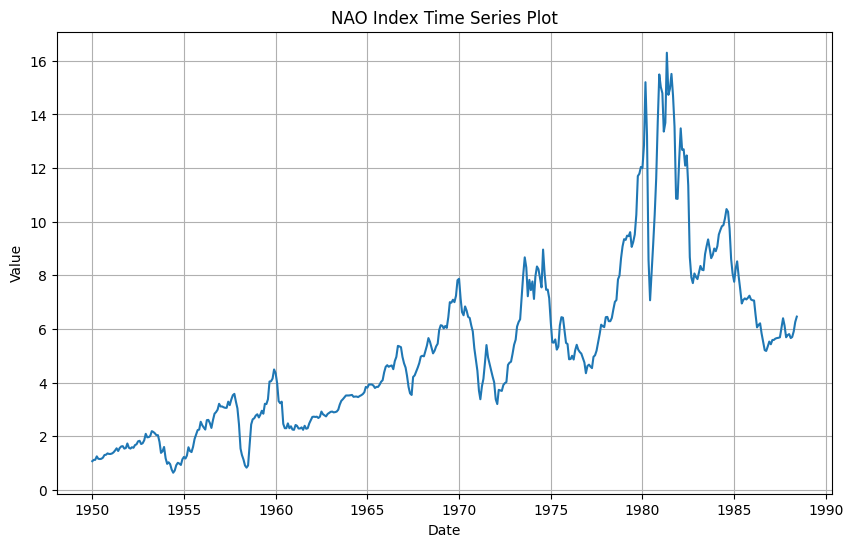

In [15]:
# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['interest_rate'],  linestyle='-')
plt.title("NAO Index Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

As the time series does not look stationary, create the log-returns of the previous data and plot them. We have done this in previous labs!

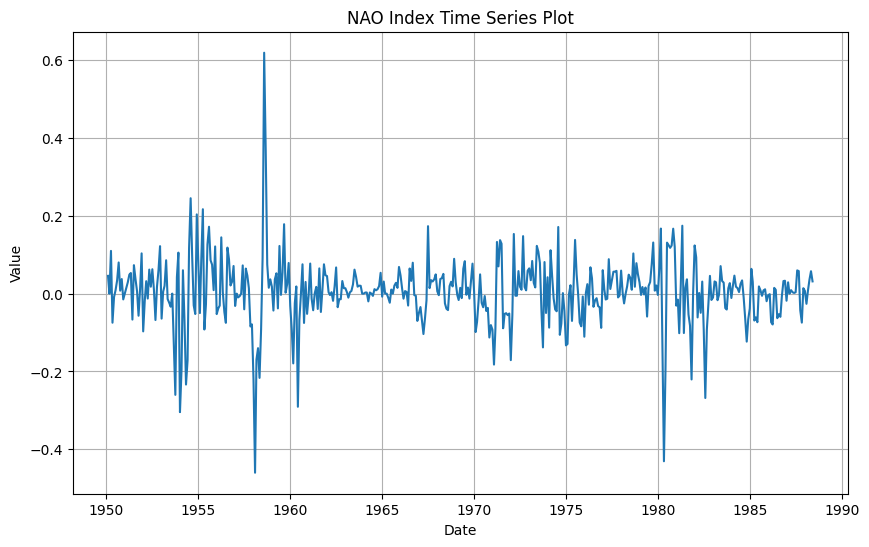

In [22]:
import numpy as np

# Calculate the log-returns: log(interest_rate_t / interest_rate_t-1)
df['log_returns'] = np.log(df['interest_rate'] / df['interest_rate'].shift(1))

# Drop the first row (NaN from shifting)
df = df.dropna()

# Plot the log-returns
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['log_returns'],  linestyle='-')
plt.title("NAO Index Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

Construct the ACF and PACF plots of the log-returns. From these plots what AR model would you expect to use?

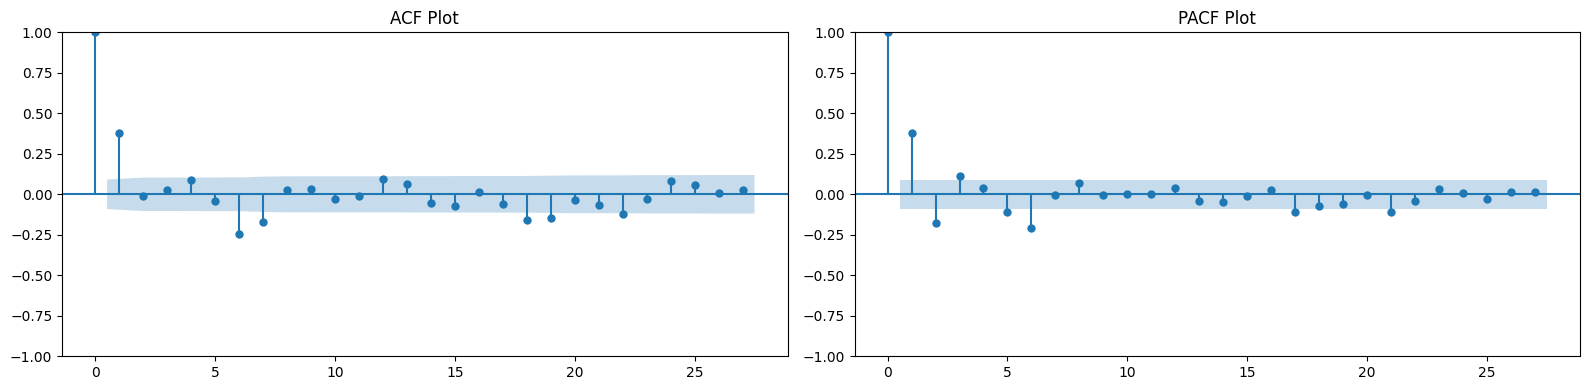

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create side-by-side ACF and PACF plots for the log-returns
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Generate the ACF plot for the 'index' column
plot_acf(df['log_returns'], ax=ax[0])
ax[0].set_title("ACF Plot")

# Generate the PACF plot for the 'index' column
plot_pacf(df['log_returns'], ax=ax[1])
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

Fit all AR(p) models for p from 1 to 10. Choose the model minimizing the BIC and plot its summary.

In [28]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(p) models for p = 1 to 10 and store BIC values and fitted results
results = []

# Fit AR(p) models for p = 1 to 10 and record AIC and BIC
for p in range(1, 11):
    model = ARIMA(df['log_returns'], order=(p, 0, 0))
    res = model.fit()
    results.append({'p': p, 'AIC': res.aic, 'BIC': res.bic})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the table of AIC and BIC values
print(results_df)

    p          AIC          BIC
0   1 -1019.691182 -1007.290988
1   2 -1031.871879 -1015.338287
2   3 -1035.773049 -1015.106058
3   4 -1034.384246 -1009.583858
4   5 -1037.884491 -1008.950704
5   6 -1056.251447 -1023.184262
6   7 -1054.254560 -1017.053978
7   8 -1054.431015 -1013.097035
8   9 -1052.432642 -1006.965264
9  10 -1050.439710 -1000.838933


For your chosen model, create the residual plots and comment on the overall quality of the model.

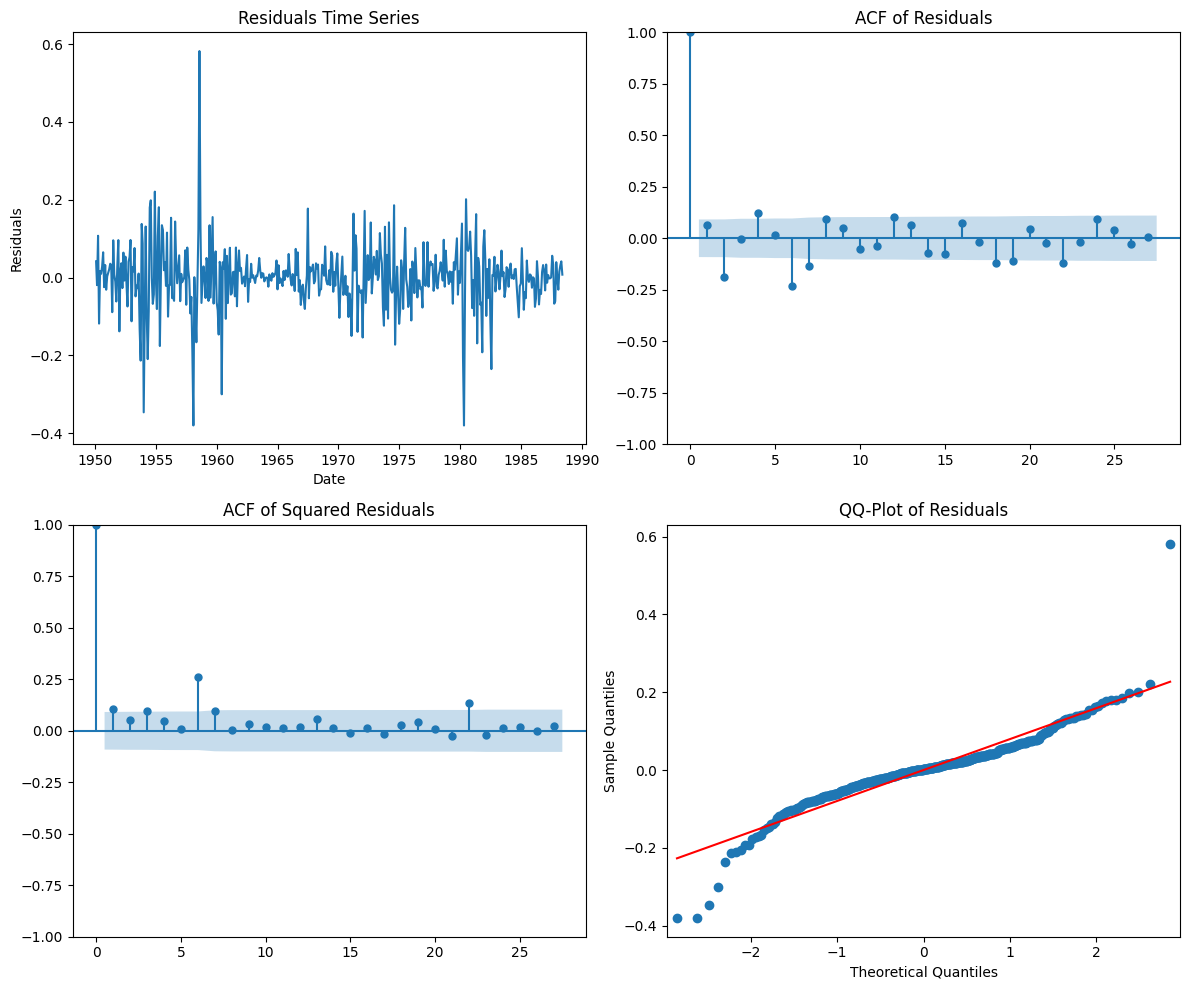

In [30]:
import statsmodels.api as sm

# Create all residual plots
model = ARIMA(df['log_returns'], order=(1, 0, 0))
results = model.fit()
resid = results.resid

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Time series plot of the residuals
axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# 2. ACF plot of the residuals
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# 3. ACF plot of the squared residuals
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# 4. QQ-plot of the residuals
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

The code below fits the model over data excluding 1988 and creates forecasts of the treasury bills. These are then plotted next to the observed values.

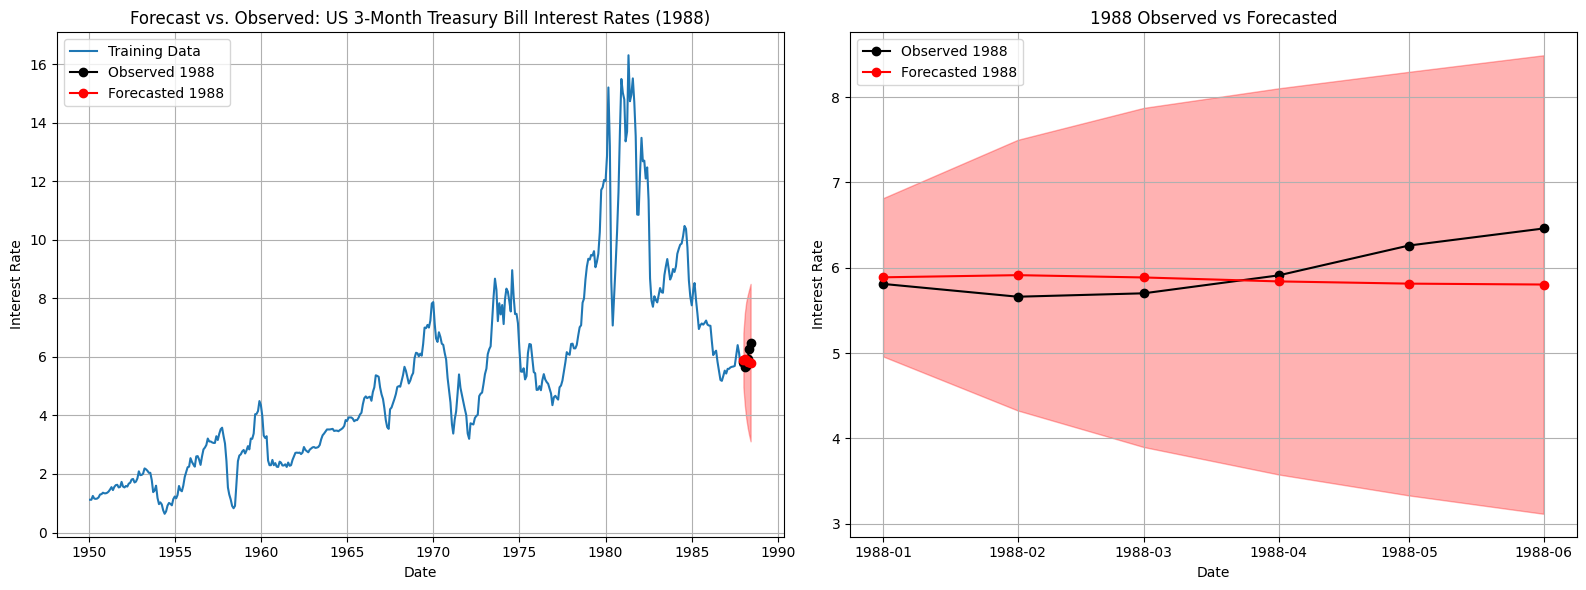

In [31]:
# Split data:
# Training set: all data before 1988
# Test set: data for 1988 (should be 6 observations: Jan 1988 to Jun 1988)
train = df[df.index.year < 1988]
test = df[df.index.year == 1988]

# Fit an AR(6) model on the original interest rate series from the training set
model = ARIMA(train['interest_rate'], order=(6, 0, 0))
results = model.fit()

# Generate a 6-steps ahead forecast (k-steps ahead for the 6 observations in 1988)
forecast_res = results.get_forecast(steps=len(test))
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Create a 1x2 grid of plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Full time series of USbill data
axes[0].plot(train.index, train['interest_rate'], label='Training Data')
axes[0].plot(test.index, test['interest_rate'], label='Observed 1988', color='black', marker='o')
axes[0].plot(forecast_mean.index, forecast_mean, label='Forecasted 1988', color='red', marker='o')
axes[0].fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='red', alpha=0.3)
axes[0].set_title("Forecast vs. Observed: US 3-Month Treasury Bill Interest Rates (1988)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Interest Rate")
axes[0].legend()
axes[0].grid(True)

# Right plot: 1988 observed values and forecast
axes[1].plot(test.index, test['interest_rate'], label='Observed 1988', color='black', marker='o')
axes[1].plot(forecast_mean.index, forecast_mean, label='Forecasted 1988', color='red', marker='o')
axes[1].fill_between(forecast_ci.index,
                     forecast_ci.iloc[:, 0],
                     forecast_ci.iloc[:, 1],
                     color='red', alpha=0.3)
axes[1].set_title("1988 Observed vs Forecasted")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Interest Rate")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()